<a href="https://colab.research.google.com/github/cest-sources/Readout_comparison_in_silico/blob/main/compare_TSE_FLASH_bSSFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq==1.3.1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

# Imports and definitions

In [ ]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [ ]:
#@title define simulate function
def simulate_brain_2D(seq_fn,verbose=False):
    # %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
    sz = [64, 64]
    # (i) load a phantom object from file
    obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')

    obj_p = obj_p.interpolate(sz[0], sz[1], 1)
    # Manipulate loaded data
    #obj_p.T2dash[:] = 30e-3
    #obj_p.D *= 0
    obj_p.B0 *= 1    # alter the B0 inhomogeneity
    # Store PD and B0 for comparison
    PD = obj_p.PD
    B0 = obj_p.B0
    if verbose:
      obj_p.plot()
    # Convert Phantom into simulation data
    obj_p = obj_p.build()


    # %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
    # Read in the sequence
    seq0 = mr0.Sequence.import_file(seq_fn)
    # Simulate the sequence
    graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
    signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

    #signal += 1e-4 * np.random.randn(signal.shape[0], 2).view(np.complex128)

    # PLOT sequence with signal in the ADC subplot
    if verbose:
      seq0.plot_kspace_trajectory()
      plt.close(11);plt.close(12)
      sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())
    return signal


In [ ]:
#@title define Recon
def recon(signal,ktraj,Nread,Nphase,verbose=False):
    # %% S6: MR IMAGE RECON of signal ::: #####################################
    kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
    permvec=np.argsort(ktraj)
    kspace=kspace_adc[:,permvec]

    spectrum = torch.fft.fftshift(kspace)  # fftshift
    space = torch.fft.fft2(spectrum)  # FFT
    space = torch.fft.ifftshift(space)# fftshift

    if verbose:
      fig = plt.figure(figsize=(8, 5))  # fig.clf()
      plt.subplot(411)
      plt.title('ADC signal')
      plt.plot(torch.real(signal), label='real')
      plt.plot(torch.imag(signal), label='imag')
      # this adds ticks at the correct position szread
      major_ticks = np.arange(0, Nphase * Nread, Nread)
      ax = plt.gca()
      ax.set_xticks(major_ticks)
      for label in ax.xaxis.get_ticklabels():
          label.set_visible(False)
      plt.xlabel('rep')
      plt.grid()

      plt.subplot(323)
      plt.title('k-space')
      plt.imshow(np.abs(kspace.numpy().T), origin="lower"); plt.axis('off');plt.colorbar()
      plt.subplot(325)
      plt.title('log. k-space')
      plt.imshow(np.log(np.abs(kspace.numpy().T)), origin="lower"); plt.axis('off');plt.colorbar()

      plt.subplot(324)
      plt.title('FFT-mag.')
      plt.imshow(np.abs(space.numpy().T), origin="lower"); plt.axis('off')
      plt.colorbar()
      plt.subplot(326)
      plt.title('FFT-phase')
      plt.imshow(np.angle(space.numpy().T), vmin=-np.pi, vmax=np.pi, origin="lower"); plt.axis('off')
      plt.colorbar()
      return kspace,space

In [ ]:
#@title def analyze
def histogram(space):# histogram
  fig = plt.figure()
  dat=np.abs(space.numpy()).flatten()
  mn=np.mean(dat)
  dat[dat<mn/2]=np.nan
  plt.hist(dat, bins=100, edgecolor='black')
  plt.title(np.mean(dat[dat>mn/2]))
  plt.xlabel('image magnitude')
  plt.ylabel('count')


from scipy.optimize import curve_fit
def PSF(kspace,verbose=False):# PSF


  def lorentzian(x, A, x0, gamma):
      return A / (1 + ((x - x0) / gamma) ** 2)

  def compute_width(y):
      x = np.arange(-Nphase // 2, Nphase // 2, 1)
      y = y / np.max(y)
      initial_guess = [1, x[np.argmax(y)], 0.1]  # Initial guess for the parameters [A, x0, gamma]
      try:
        params, _ = curve_fit(lorentzian, x, y, p0=initial_guess)
      except:
        params=initial_guess

      A, x0, gamma = params

      if verbose:
        plt.figure()
        plt.plot(lorentzian(x,A,x0,gamma))
      fwhm = 2 * np.abs(gamma)
      return fwhm

  MTF=np.abs(kspace[Nread//2,:])
  PSF=np.abs(np.fft.fftshift(np.fft.fft(MTF)))
  PSFideal=np.fft.fftshift(np.fft.fft(MTF*0+5))
  fig = plt.figure()
  plt.plot(PSF,'.-');
  plt.title(compute_width(PSF))
  plt.show()
  #plt.plot(PSFideal,'.-');
  #plt.title(compute_width(np.abs(PSFideal)))





In [ ]:
#@title Define TSE in PyPulseq
def tse_sequence(system, fov=200e-3, Nread=128, Nphase=128, shots=1, FAex=90, FAref=180,
                 slice_thickness=8e-3, TE=12e-3, TR=2000e-3, PEtype='centric', dwell_time=None,
                 PE_flag=True, P_gspoil=1,seq_id = 'TSE_2D'):
    """
    Define a Turbo Spin Echo (TSE) sequence with the given parameters.

    Parameters:
    - system: MRI system configuration
    - fov: Field of view (in meters)
    - Nread: Number of readout points
    - Nphase: Number of phase encoding points
    - shots: Number of shots
    - FAex: Flip angle for excitation pulse (in degrees)
    - FAref: Flip angle for refocusing pulse (in degrees)
    - sliceThickness: Slice thickness (in meters)
    - TE: Echo time (in seconds)
    - TR: Repetition time (in seconds)
    - PEtype: Phase encoding type ('centric', etc.)
    - dwell_time: Dwell time or bandwidth
    - PEflag: Phase encoding flag (True or False)
    - gspoil: Gradient spoil factor

    Returns:
    - A seq object
    """
    sequence_params = locals()

    # %% S2. DEFINE the sequence
    seq = pp.Sequence()

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=2e-3, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=2e-3, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
    gx_pre = pp.make_trapezoid(channel='x',  area=gx.area/2 +1.0*gx.area, duration=2e-3, system=system)
    gx_spoil = pp.make_trapezoid(channel='x',area=          +1.0*gx.area, duration=1e-3, system=system)

    rf_phase = 0
    rf_inc = 0
    rf_spoiling_inc = 84

    # Define rf events
    rf_IR, _, _ = pp.make_sinc_pulse(
        flip_angle=  180* np.pi / 180, phase_offset=90* np.pi / 180, duration=0.5e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )
    gz_spoil = pp.make_trapezoid(channel='z',area=64, duration=1e-3, system=system)


    rf_ex, _, _ = pp.make_sinc_pulse(
        flip_angle=  90* np.pi / 180, phase_offset=90* np.pi / 180, duration=0.5e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )
    rf_ref, _, _ = pp.make_sinc_pulse(
        flip_angle=P_FA* np.pi / 180, duration=0.5e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    ##linear reordering
    phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
    permvec =np.arange(0, Nphase, 1)
    ## centric reordering
    permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
    ## random reordering
    #perm =np.arange(0, Nphase, 1);  permvec = np.random.permutation(perm)

    phenc_centr = phenc[permvec] *PE_flag
    gp = pp.make_trapezoid(channel='y', area=0, duration=1e-3, system=system)

    TE= 0.5e-3+ pp.calc_duration(gp)+pp.calc_duration(gx)+pp.calc_duration(gp) + pp.calc_duration(rf_ex)
    print("TE [ms] = ",TE*1000)


    ktraj=np.array([])

    for jj in range(0,shots):
      seq.add_block(pp.make_delay(5))
      seq.add_block(rf_IR)
      seq.add_block(gz_spoil)
      seq.add_block(pp.make_delay(2.7))

      seq.add_block(rf_ex)
      seq.add_block(pp.make_delay(TE/2 -pp.calc_duration(gx_pre)- pp.calc_duration(rf_ex)))
      seq.add_block(gx_pre)
      phenc_centr_shot=phenc_centr[jj::shots]
      for ii in range(0, Nphase//shots):  # e.g. -64:63
          seq.add_block(rf_ref)
          seq.add_block(pp.make_delay(0.5e-3))

          if PE_flag:
            ktraj=np.append(ktraj,phenc_centr_shot[ii])

          gp = pp.make_trapezoid(channel='y', area=+phenc_centr_shot[ii], duration=1e-3, system=system)
          if P_gspoil  and PE_flag:
            seq.add_block(gx_spoil, gp)
          elif P_gspoil:
            seq.add_block(gx_spoil)
          elif P_PE:
            seq.add_block(gp)
          else:
            seq.add_block(pp.make_delay(pp.calc_duration(gp)))

          seq.add_block(adc, gx)

          gp = pp.make_trapezoid(channel='y', area=-phenc_centr_shot[ii], duration=1e-3, system=system)
          if P_gspoil  and PE_flag:
            seq.add_block(gx_spoil, gp)
          elif P_gspoil:
            seq.add_block(gx_spoil)
          elif P_PE:
            seq.add_block(gp)
          else:
            seq.add_block(pp.make_delay(pp.calc_duration(gp)))

    # %% S3. CHECK, PLOT and WRITE the sequence  as .seq
    # Check whether the timing of the sequence is correct
    ok, error_report = seq.check_timing()
    if ok:
        print('Timing check passed successfully')
    else:
        print('Timing check failed. Error listing follows:')
        [print(e) for e in error_report]

    # PLOT sequence
    #sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

    # Prepare the sequence output for the scanner
    seq.set_definition('FOV', [fov, fov, slice_thickness])
    seq_fn= seq_id + '.seq'
    seq.write(seq_fn)

    return seq,seq_fn,ktraj



In [ ]:
#@title Define SSFP in PyPulseq
def ssfp_sequence(system, fov=200e-3,Nread=64, Nphase=64, FAex=10,P_alpha_half=0,
                 slice_thickness=8e-3,
                 TE=12e-3, TR=2000e-3,
                 TR_delay=0,
                 PEtype='centric',
                 dwell_time=None,
                 PE_flag=True,P_PE_rewinder_flag=True,
                 P_gspoil="read spoiler",P_rf_cycling="84° quadr. rf spoil",seq_id = 'ssfp'):

    """
    Define a ssfp sequence with the given parameters.

    Parameters:
    - system: MRI system configuration
    - fov: Field of view (in meters)
    - Nread: Number of readout points
    - Nphase: Number of phase encoding points
    - FAex: Flip angle for excitation pulse (in degrees)
    - slice_thickness: Slice thickness (in meters)
    - TE: Echo time (in seconds)
    - TR: Repetition time (in seconds)
    - PEtype: Phase encoding type ('linear', etc.)
    - dwell_time: Dwell time or bandwidth
    - PEflag: Phase encoding flag (True or False)
    - P_PE_rewinder_flag: phase rewinder (True or False)
    - gspoil: Gradient spoil factor
    - P_rf_cycling: physe cycling type

    Returns:
    - A seq object
    """
    sequence_params = locals()


    # %% S2. DEFINE the sequence
    seq = pp.Sequence()

    # Define FOV and resolution
    fov = 200e-3
    slice_thickness = 8e-3
    sz = (32, 32)   # spin system size / resolution
    Nread = 64    # frequency encoding steps/samples
    Nphase = 64    # phase encoding steps/samples


    # rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=2e-3, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=2e-3, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
    gx_spoil = pp.make_trapezoid(channel='x', area=1.0 * gx.area, duration=1e-3, system=system)

    rf_phase = 0
    rf_inc = 0
    rf_spoiling_inc = 84

    if P_gspoil=="balancing":
      gx_spoil = gx_pre

    # Define rf events
    rf_IR, _, _ = pp.make_sinc_pulse(
        flip_angle=  180* np.pi / 180, phase_offset=90* np.pi / 180, duration=0.5e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )
    gz_spoil = pp.make_trapezoid(channel='z',area=64, duration=1e-3, system=system)

    rf1, _, _ = pp.make_sinc_pulse(
        flip_angle= P_FA * np.pi / 180, duration=0.5e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )
    rf0, _, _ = pp.make_sinc_pulse(
        flip_angle=P_FA/2* np.pi / 180, duration=0.5e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True
    )

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    ##linear reordering
    phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
    permvec =np.arange(0, Nphase, 1)
    ## centric reordering
    permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
    ## random reordering
    #perm =np.arange(0, Nphase, 1);  permvec = np.random.permutation(perm)

    phenc_centr = phenc[permvec] *PE_flag

    ktraj=np.array([])

    seq.add_block(rf_IR)
    seq.add_block(gz_spoil)
    seq.add_block(pp.make_delay(2.7))

    if P_alpha_half:
      seq.add_block(rf0)
      seq.add_block(pp.make_delay(3.01e-3-pp.calc_duration(rf1) ))
    for ii in range(0, Nphase):  # e.g. -64:63

        if P_rf_cycling == "84° quadr. rf spoil":
          rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
          adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
          rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
          # increment additional pahse
          rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]
        elif P_rf_cycling == "180° cycling":
          rf_phase = divmod(rf_phase + 180, 360.0)[1]
          rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
          adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC


        ktraj=np.append(ktraj,phenc_centr[ii])
        seq.add_block(rf1)
        seq.add_block(pp.make_delay(0.0005))
        gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=1e-3, system=system)
        seq.add_block(gx_pre, gp)
        seq.add_block(adc, gx)
        gp = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=1e-3, system=system)
        if not(P_gspoil =="no spoiler") and P_PE_rewinder_flag:
          seq.add_block(gx_spoil, gp)
        elif not(P_gspoil =="no spoiler"):
          seq.add_block(gx_spoil)
        elif P_PE_rewinder_flag:
          seq.add_block(gp)
        else:
          seq.add_block(pp.make_delay(pp.calc_duration(gp)))
        if ii < Nphase - 1:
            seq.add_block(pp.make_delay(TR_delay))

    TR= pp.calc_duration(rf1) + pp.calc_duration(gx_pre)+pp.calc_duration(gx)+pp.calc_duration(gp)
    print("TR [ms] = ",TR*1000)
    # %% S3. CHECK, PLOT and WRITE the sequence  as .seq
    # Check whether the timing of the sequence is correct
    ok, error_report = seq.check_timing()
    if ok:
        print('Timing check passed successfully')
    else:
        print('Timing check failed. Error listing follows:')
        [print(e) for e in error_report]

    # PLOT sequence
    #sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

    # Prepare the sequence output for the scanner
    seq.set_definition('FOV', [fov, fov, slice_thickness])
    seq_fn= seq_id + '.seq'
    seq.write(seq_fn)

    return seq,seq_fn,ktraj



# RUNs

TE [ms] =  6.5200000000000005
Timing check passed successfully
TE [ms] =  6.5200000000000005
Timing check passed successfully


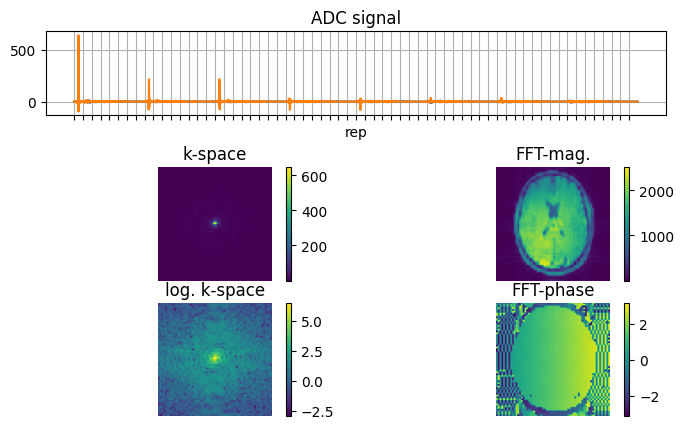

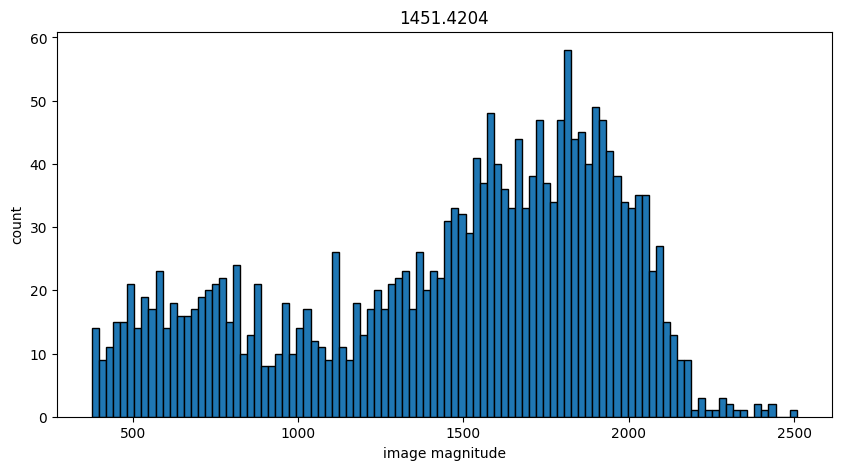

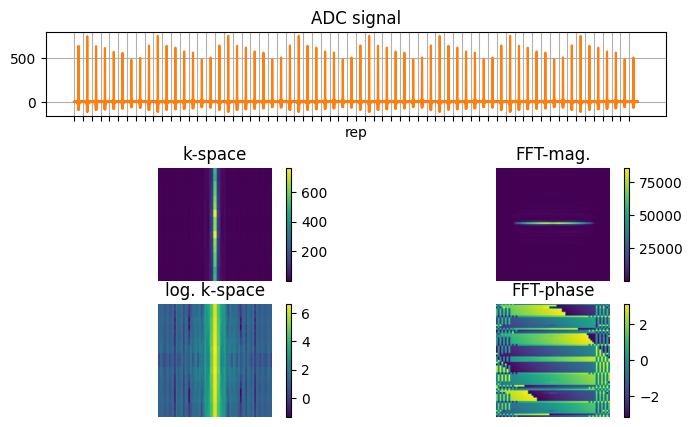

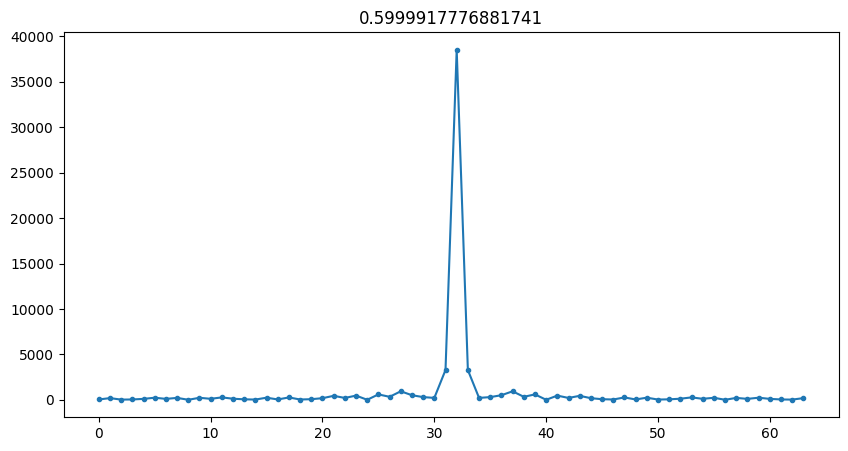

In [ ]:
#@title RUN TSE
#@markdown You can steer different settings by the sliders
P_FA=120         #@param {type: "slider", min: 1, max: 270}
P_shots = 8 # @param {type:"slider", min:1, max:8, step:1}

# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s', rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)
Nread = 64
Nphase= 64

seq,seq_fn,ktraj=tse_sequence(system, fov=200e-3,
                 Nread=Nread, Nphase=Nphase, shots=P_shots,
                 FAex=90, FAref=P_FA,
                 slice_thickness=8e-3,
                 TE=12e-3, TR=2000e-3,
                 PEtype='linear',
                 dwell_time=None,
                 PE_flag=True, P_gspoil=True)

signal   = simulate_brain_2D(seq_fn,verbose=False)

seq,seq_fn,_=tse_sequence(system, fov=200e-3,
                 Nread=Nread, Nphase=Nphase, shots=P_shots,
                 FAex=90, FAref=P_FA,
                 slice_thickness=8e-3,
                 TE=12e-3, TR=2000e-3,
                 PEtype='linear',
                 dwell_time=None,
                 PE_flag=False, P_gspoil=True)
signal_noPE = simulate_brain_2D(seq_fn,verbose=False)

kspace,space = recon(signal,ktraj,Nread,Nphase,verbose=True)

histogram(space)

kspace,space = recon(signal_noPE,ktraj,Nread,Nphase,verbose=True)
PSF(kspace)

TR [ms] =  6.0200000000000005
Timing check passed successfully
TR [ms] =  6.0200000000000005
Timing check passed successfully


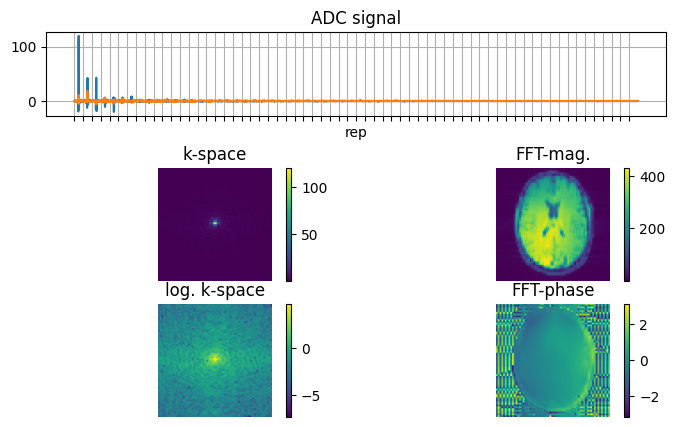

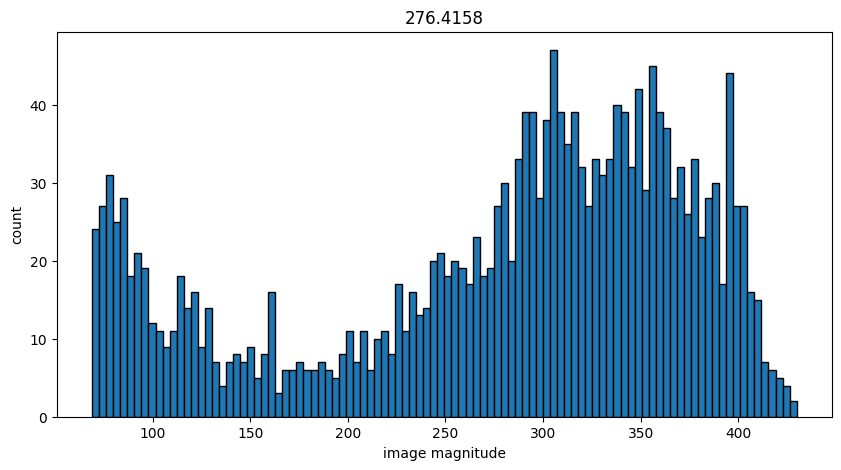

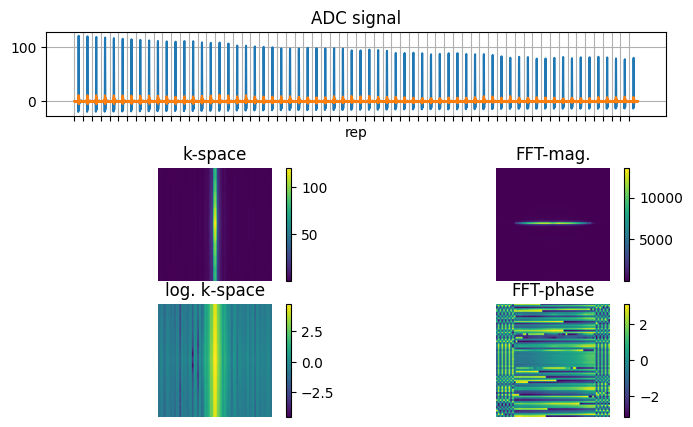

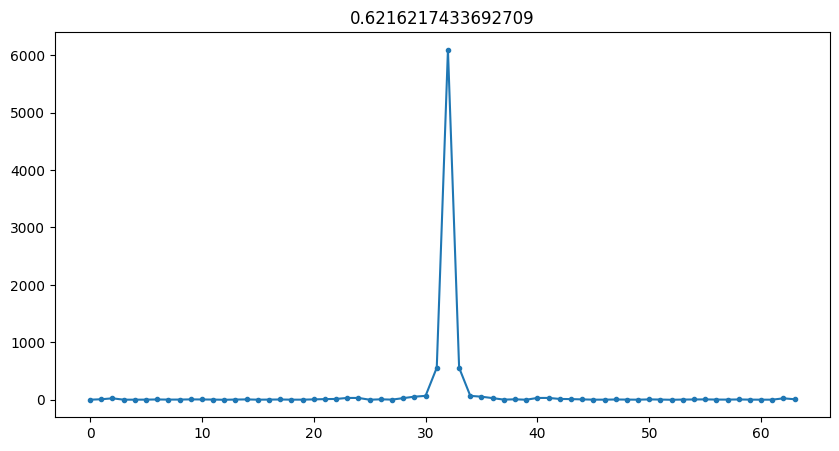

In [ ]:
#@title RUN FLASH
P_FA=8         #@param {type: "slider", min: 1, max: 180}

# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s', rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)
Nread = 64
Nphase= 64

seq,seq_fn,ktraj=ssfp_sequence(system, fov=200e-3,
                 Nread=Nread, Nphase=Nphase,
                 FAex=P_FA,P_alpha_half=0,
                 slice_thickness=8e-3,
                 TE=12e-3, TR=2000e-3,
                 TR_delay=0,
                 PEtype='linear',
                 dwell_time=None,
                 PE_flag=True,P_PE_rewinder_flag=True,
                 P_gspoil="read spoiler",P_rf_cycling="84° quadr. rf spoil")

signal   = simulate_brain_2D(seq_fn,verbose=False)

seq,seq_fn,_=ssfp_sequence(system, fov=200e-3,
                 Nread=Nread, Nphase=Nphase,
                 FAex=P_FA,P_alpha_half=0,
                 slice_thickness=8e-3,
                 TE=12e-3, TR=2000e-3,
                 TR_delay=0,
                 PEtype='linear',
                 dwell_time=None,
                 PE_flag=False,P_PE_rewinder_flag=False,
                 P_gspoil="read spoiler",P_rf_cycling="84° quadr. rf spoil")

signal_noPE = simulate_brain_2D(seq_fn,verbose=False)

kspace,space = recon(signal,ktraj,Nread,Nphase,verbose=True)

histogram(space)

kspace,space = recon(signal_noPE,ktraj,Nread,Nphase,verbose=True)
PSF(kspace)

TR [ms] =  6.0200000000000005
Timing check passed successfully
TR [ms] =  6.0200000000000005
Timing check passed successfully


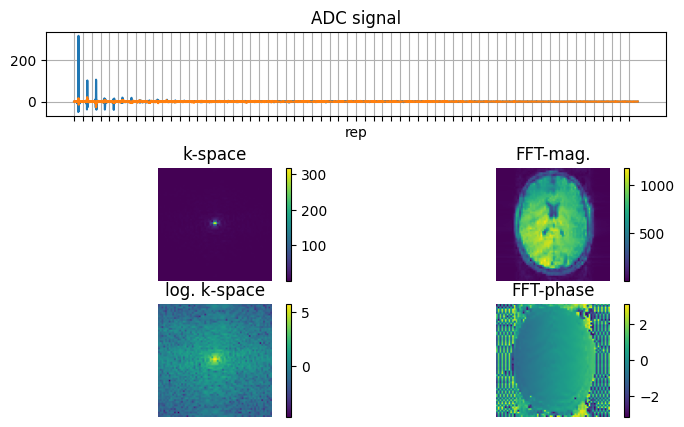

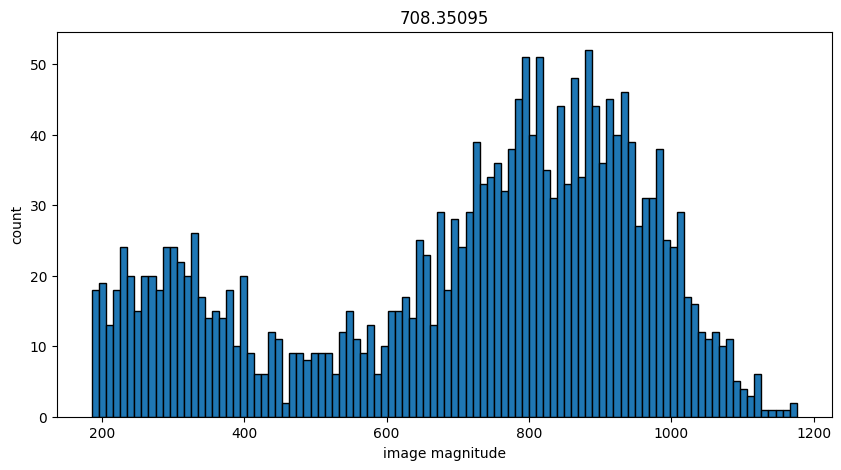

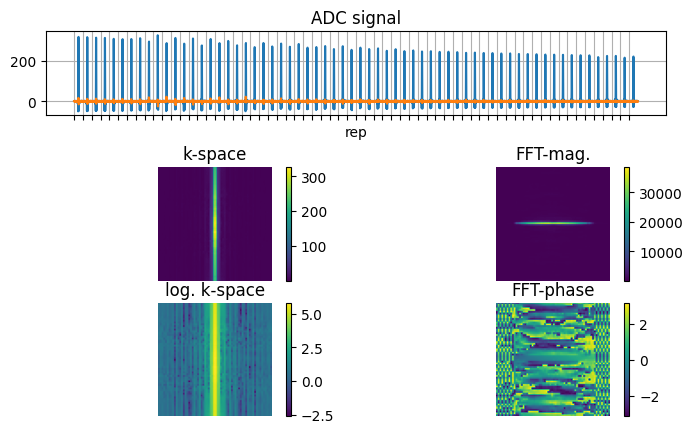

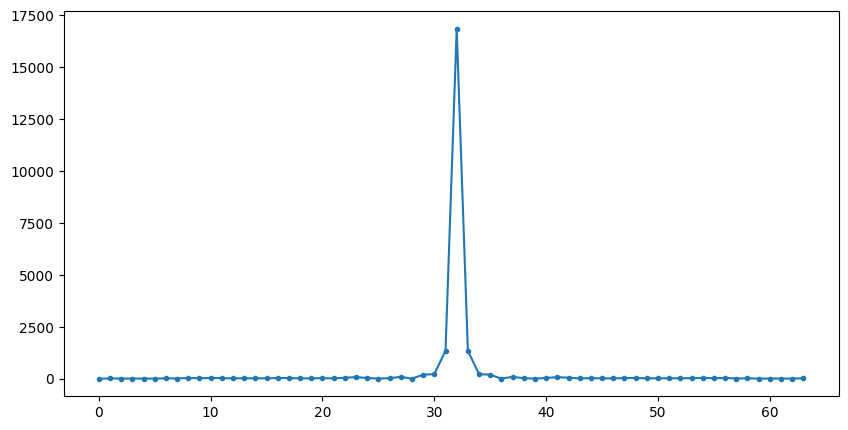

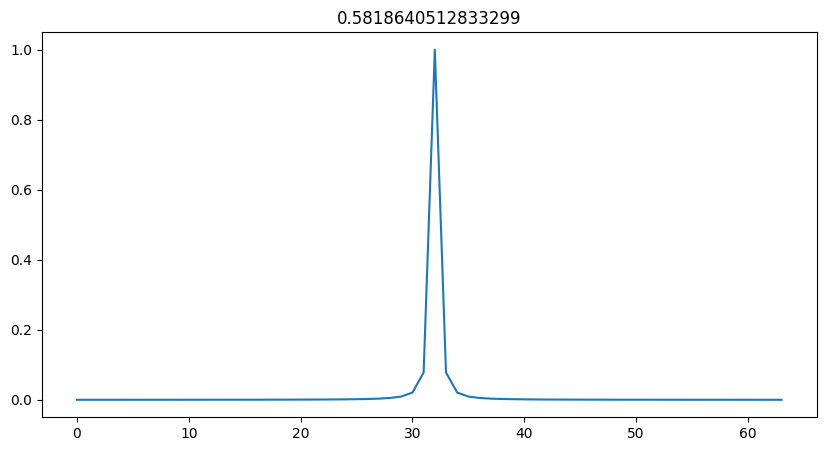

In [ ]:
#@title RUN bSSFP
P_FA=40         #@param {type: "slider", min: 1, max: 180}

# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s', rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)
Nread = 64
Nphase= 64

seq,seq_fn,ktraj=ssfp_sequence(system, fov=200e-3,
                 Nread=Nread, Nphase=Nphase,
                 FAex=P_FA,P_alpha_half=1,
                 slice_thickness=8e-3,
                 TE=12e-3, TR=2000e-3,
                 TR_delay=0,
                 PEtype='linear',
                 dwell_time=None,
                 PE_flag=True,P_PE_rewinder_flag=True,
                 P_gspoil="balancing",P_rf_cycling="180° cycling")

signal   = simulate_brain_2D(seq_fn,verbose=False)

seq,seq_fn,_=ssfp_sequence(system, fov=200e-3,
                 Nread=Nread, Nphase=Nphase,
                 FAex=P_FA,P_alpha_half=1,
                 slice_thickness=8e-3,
                 TE=12e-3, TR=2000e-3,
                 TR_delay=0,
                 PEtype='linear',
                 dwell_time=None,
                 PE_flag=False,P_PE_rewinder_flag=False,
                 P_gspoil="balancing",P_rf_cycling="180° cycling")

signal_noPE = simulate_brain_2D(seq_fn,verbose=False)

kspace,space = recon(signal,ktraj,Nread,Nphase,verbose=True)

histogram(space)

kspace,space = recon(signal_noPE,ktraj,Nread,Nphase,verbose=True)
PSF(kspace,True)

## Plot

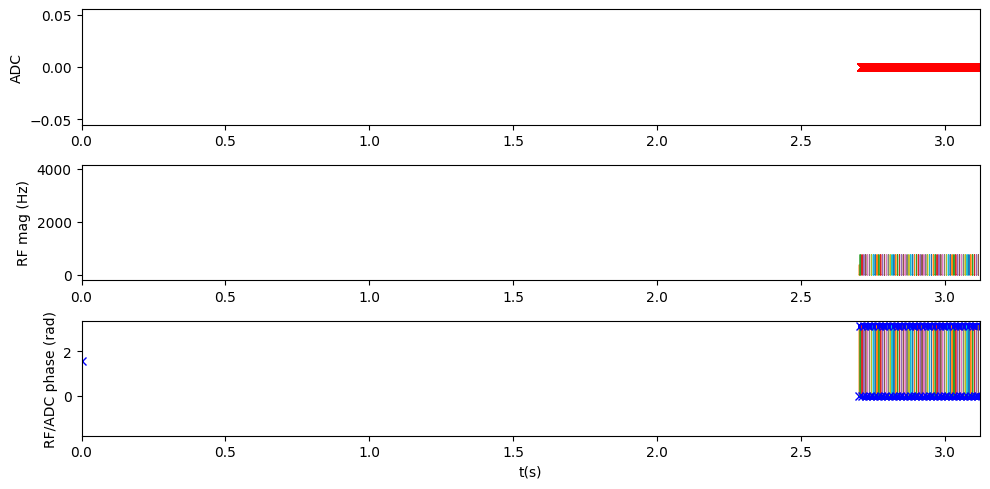

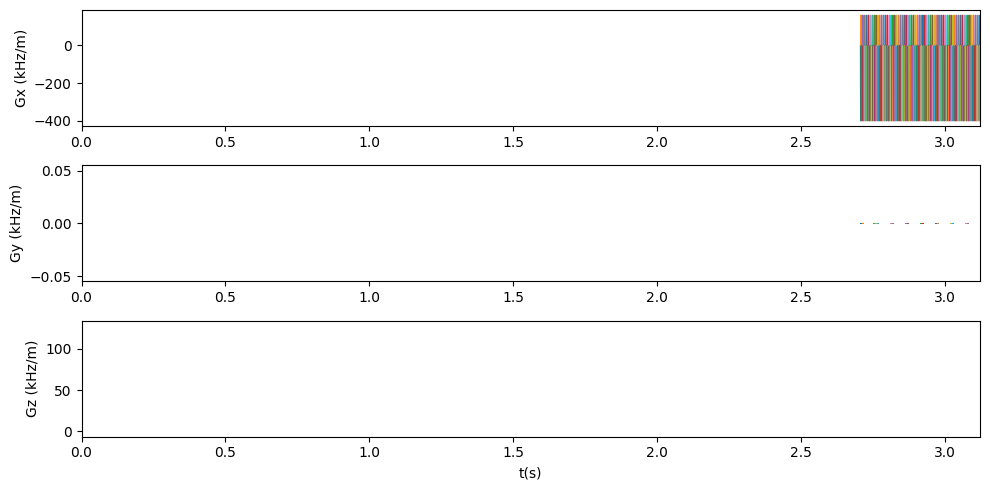

In [ ]:
#seq.plot(time_range=(7.74,7.744))
seq.plot()

# Load Phantom, simulate, recon

# Analyze

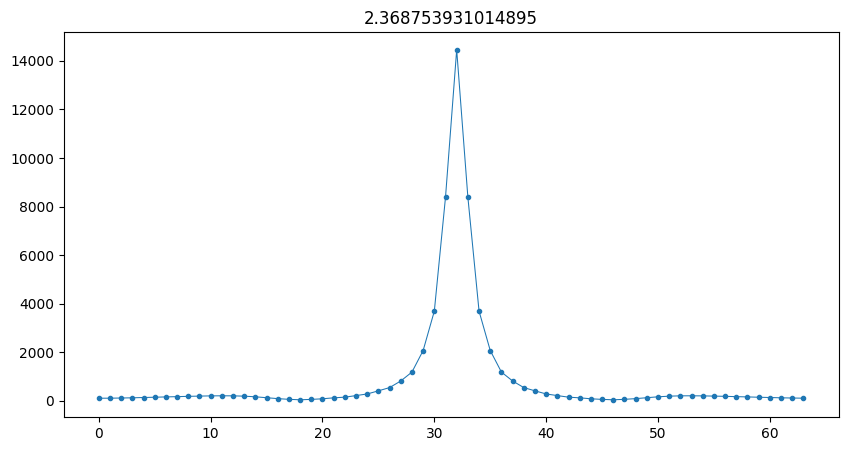

Text(0.5, 1.0, '9.032566368946184e-06')

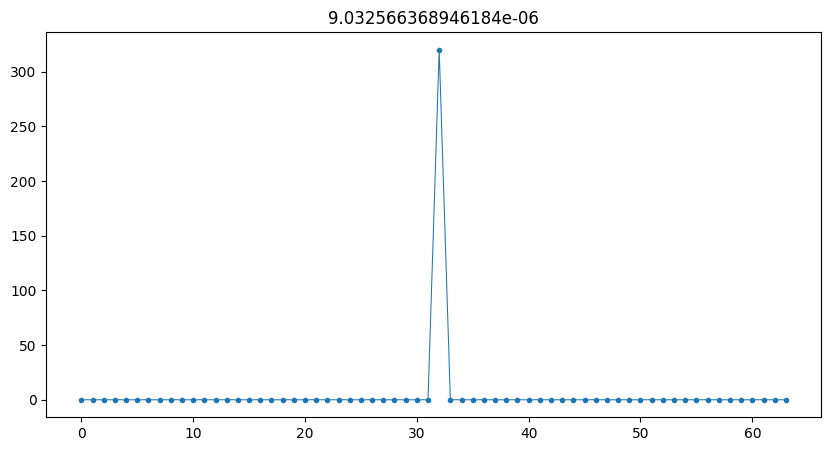

In [ ]:
import numpy as np
import scipy.io

# Save the arrays to a .mat file
scipy.io.savemat('TSE_data.mat', {'dat': dat, 'space': space, 'PSF': PSF})
